In [2]:
import numpy as onp
import math
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import gzip
from jax.config import config
config.update("jax_enable_x64", True)
import neural_tangents as nt  # 64-bit precision enabled
from neural_tangents import stax
from jax import random, vmap
from jax.api import jit
from jax.api import grad
from jax.experimental import optimizers
from Utils.Utils_misc_functions import generate_datasets

## Data Loading and conversion

Below are functions I used to generate the data. train_data and test_data are dictionaries {'image':X, 'label': Y}. 
<br>
X are the images of size (32 x 32 x 3). Y represents one-hot encoded labels of dimension 10, where off entries are equal to -0.1 and on entries are equal to 0.9. <br>
For demonstration purposes, I picked **200 training points and 50 test points**

In [3]:
train_size = 200
test_size = 50
train_data, test_data = generate_datasets(train_size=train_size, test_size=test_size, flatten=False)

In [4]:
train_data.keys()

dict_keys(['image', 'label'])

/dora/users/stfour/tuoz/stax_computing/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Text(0.5, 1.0, 'Distribution of classes in training data')

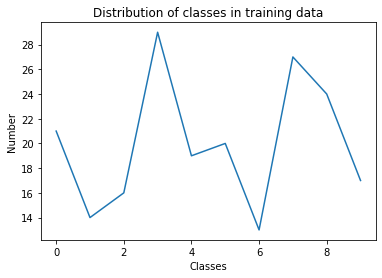

In [5]:
number_classes = np.sum(train_data['label'] > 0, axis = 0)
plt.plot(range(10), number_classes)
plt.xlabel('Classes')
plt.ylabel('Number')
plt.title('Distribution of classes in training data')

## Modelling

The function below generates a CNN network with "depth" number of hidden layers and Relu activation. The final layer flattens the outputs of the last CNN layer before feeding it to a fully connected layer. The parameters are depth of the network and variance of the weights and biases. It returns 3 functions; init_fn, apply_fn and kernel_fn. kernel_fn refers to the infinite width version of the given architecture whilst the other two refer to the finite version. <br>
* **init_fn** : a function to initialise parameters of the network 
* **apply_fn**: a function for forward propogation; calculates outputs of the network given the inputs (images) 
* **kernel_fn**: The kernel function of the infinite network (GP), with options for both NTK and NNGP kernels. 

In [6]:
key = random.PRNGKey(0)
def ConvolutionalNetwork(depth, W_std=1.0, b_std=0.0):
    layers = []
    for _ in range(depth):
        layers += [stax.Conv(1, (3, 3), W_std = W_std, b_std = b_std, padding='SAME'), stax.Relu()]
    layers += [stax.Flatten(), stax.Dense(10, W_std, b_std)]    
    return stax.serial(*layers)

With the above functions defined, we can now create the functions for our specific architecture. Our NN will be a 2 hidden layer CNN. 

In [7]:
# Generate functions
depth = 2
init_fn, apply_fn, kernel_fn = ConvolutionalNetwork(depth = depth)

# Batched kernel_fn
batch_size = math.gcd(train_size, test_size)
batched_kernel_fn = nt.batch(kernel_fn, batch_size=10, store_on_device= False)

# Initial parameters. (32,32,3) is the dimension of each image
_, initial_params = init_fn(key, (-1, 32, 32, 3))

We can generate the outputs for the first 3 images in our training dataset. As expected, this returns a 3 x 10 output matrix

In [8]:
apply_fn(initial_params, train_data['image'][:3])

/dora/users/stfour/tuoz/stax_computing/lib/python3.7/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


DeviceArray([[ 0.07063823, -0.12127789, -1.0885475 , -0.77978387,
              -0.34610889, -0.48096224,  0.37467043, -0.16124008,
              -0.23247861, -0.61823059],
             [-0.04603397, -0.57805611, -0.61686252,  0.52422678,
              -0.53794736,  0.34639732,  0.32485144, -0.20444674,
               0.59591507, -0.37671545],
             [ 0.17648354, -0.32829869, -0.62099431,  0.33338067,
               0.02851771, -0.53202541, -0.06019741, -0.04101137,
               0.09568016,  0.21143802]], dtype=float64)

We can also calculate the covariance matrix for these 3 images, for both the NNGP (Bayesian infinite NN) and NTK (gradient descent trained infinite network)

In [9]:
kernel_fn(train_data['image'][:3], train_data['image'][:3])

/dora/users/stfour/tuoz/stax_computing/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Kernel(nngp=DeviceArray([[0.22593311, 0.12790779, 0.12160144],
             [0.12790779, 0.23514147, 0.12030579],
             [0.12160144, 0.12030579, 0.23931955]], dtype=float64), ntk=DeviceArray([[0.67779934, 0.23323209, 0.22273706],
             [0.23323209, 0.70542441, 0.20808586],
             [0.22273706, 0.20808586, 0.71795864]], dtype=float64), cov1=DeviceArray([0.22593311, 0.23514147, 0.23931955], dtype=float64), cov2=DeviceArray([0.22593311, 0.23514147, 0.23931955], dtype=float64), x1_is_x2=DeviceArray(True, dtype=bool), is_gaussian=True, is_reversed=False, is_input=False, diagonal_batch=True, diagonal_spatial=False, shape1=(3, 10), shape2=(3, 10), batch_axis=0, channel_axis=1, mask1=None, mask2=None)

The core of Neural Tangents is a map $\mathcal T$ for a wide range of architectures such that $K^{l + 1} = \mathcal T(K^l)$. This means that given a single neural network layer for which we know the kernel, neural tangents allows us to calculate the kernel of the resulting architecture after applying a subsequent neural network layer. Hence, we can calculate kernels of complex architectures by composing the kernels of each individual layer. 
<br><br>
For example, the block below computes the kernel function for a CNN layer and FCN layer. We can calculate the kernel of an architecture of a CNN layer followed by a FCN layer by composing these individual kernels. Alternatively, we can just use stax.serial like above to automatically get the resulting kernel of an architecture. 

In [33]:
ex_cnn_layer = stax.Conv(1, (3,3), (5,5), padding='SAME')[2]
ex_fcn_layer = stax.Dense(1)[2]
ex_combined = stax.serial(stax.Conv(1, (3,3), (5,5), padding='SAME'), stax.Dense(1))[2]

In [42]:
(ex_fcn_layer(ex_cnn_layer(test_data['image'])).ntk == ex_combined(test_data['image']).ntk).all()

DeviceArray(True, dtype=bool)

In [35]:
ex_fcn_layer(ex_cnn_layer(test_data['image'])).ntk

DeviceArray([[[[[[ 1.55087485e-01, -1.27928798e-01, -1.84347549e-01,
                  ...,  3.07800722e-01,  3.30656377e-01,
                   2.99527015e-01],
                 [-1.27928798e-01,  5.62649399e-01,  7.70747906e-01,
                  ..., -1.23829791e+00, -1.32233266e+00,
                  -9.44434526e-01],
                 [-1.84347549e-01,  7.70747906e-01,  1.07795340e+00,
                  ..., -1.73630442e+00, -1.85379895e+00,
                  -1.28658134e+00],
                 ...,
                 [ 3.07800722e-01, -1.23829791e+00, -1.73630442e+00,
                  ...,  2.83324679e+00,  3.02273535e+00,
                   2.00165748e+00],
                 [ 3.30656377e-01, -1.32233266e+00, -1.85379895e+00,
                  ...,  3.02273535e+00,  3.22522611e+00,
                   2.14905227e+00],
                 [ 2.99527015e-01, -9.44434526e-01, -1.28658134e+00,
                  ...,  2.00165748e+00,  2.14905227e+00,
                   2.15905750e+00]],

    

## Prediction

Prediction involves calculating the Posterior predictive distribution of the GP, $P(X_{test} | X_{train}, Y_{train}, K)$, where K refers to the kernel function<br>

Ensemble means that the architecture is not dependent on $f_0(x_{train})$, or $f_0(x_{test})$, the train and test outputs of the network at initialisation. i.e. Not dependent on initialisation of variables. 

In [11]:
# GP inference posterior ENSEMBLE

predict_fn = nt.predict.gradient_descent_mse_ensemble(batched_kernel_fn,train_data['image'], train_data['label'])
#train_mean, train_cov = predict_fn(x_test=train_data['image'], get='ntk', compute_cov=True)
train_mean, train_cov = predict_fn(compute_cov = True).ntk
test_mean, test_cov = predict_fn(x_test=test_data['image'], get='ntk', compute_cov=True)

In [12]:
print('The shape of the test mean is {} and the shape of the test covariance matrix is {}'.format(
    test_mean.shape, test_cov.shape))

The shape of the test mean is (50, 10) and the shape of the test covariance matrix is (50, 50)


We can then use the mean of the posterior predictive distribution as the predictions to calculate metrics like loss and accuracy. Note that the mean of the training predictive distribution will always equal $Y_{train}$, meaning that loss and accuracy will always be 0 and 100% respectively. 

In [13]:
# METRICS

# MSE loss
loss = lambda y_hat, y: 0.5 * np.mean((y_hat - y) ** 2)

# Accuracy
def accuracy(predicted, targets):
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(predicted, axis = 1)
    return np.mean(predicted_class == target_class)

The accuracy below is only 0.36 but if the GP is fed more training points, the accuracy will be a lot higher. 

In [26]:
print('For the test data, the loss is {:4f} and the accuracy is {:4f}'.format(
    loss(test_mean, test_data['label']), accuracy(test_mean, test_data['label'])))

For the test data, the loss is 0.041812 and the accuracy is 0.360000


## Calculating the Marginal Log Likelihood of a GP

The marginal log-likelihood, according to Rasmussen is:<br>
<br>
$log(p(Y|x) = -\frac{1}{2}y^TK_y^{-1}y - \frac{1}{2}log(|K_y|) - \frac{n}{2}log(2\pi)$ <br>

Where:
* $K_y$ is be a $Cn \times Cn$ covariance matrix, where C is the number of classes and n is the number of training or test points. For training points, I take this to be $K(X_{train}, X_{train})$ and for test points, I use $K(X_{test}, X_{test})$
* $Y$ is a flattened $Cn \times 1$ shaped vector of the outputs of the NN<br>

In the infinite width limit, the kernel matrix becomes a block diagonal and is to be interpreted as $K \otimes I$. According to the documentation, the covariance along channel/feature/logit axes converges to a constant-diagonal matrix. This means that there is no covariance between the different neurons of the output layer. This makes sense because if you consider a fully connected network, as the width tends to infinity, there is an infinite number of neurons. <br>
<br>
In the functions below, since the kernel functions $K_y$ are only of size nxn, I repeat it along the diagonals 10 times becuase the outputs of CIFAR-10 are of dimension 10

In [18]:
def repeat_along_diag(a, r):
    '''
    This functions repeats a matrix a along the diagonal r times. If the dimension of matrix a is (m x n)
    will return a matrix of shape (mxr) x (nxr)
    '''
    m,n = a.shape
    out = onp.zeros((r,m,r,n), dtype=a.dtype)
    diag = onp.einsum('ijik->ijk',out)
    diag[:] = a
    return out.reshape(-1,n*r)

def marginal_log_likelihood(Y, cov, dim = 10):
    '''
    Calculates the marginal log likelihood of predictions
    '''
    # Shape (n, 1)
    y = Y.flatten('F')[:np.newaxis] 
    # Shape (1,n)
    y_t = Y.flatten('F')[np.newaxis, :]
    # Shape (nd x nd)
    cov_inv = np.linalg.inv(cov)
    # Shape (nd x nd)
    cov_inv_big = repeat_along_diag(cov_inv, dim)
    likelihood_term = -0.5*(y_t @ cov_inv_big @ y)
    
    cov_determinant = np.linalg.det(cov)
    determinant_term = -0.5*dim*np.log(cov_determinant + 1e-8)
    
    constant_term = -((dim*1)/2)*np.log(2*np.pi)
    return likelihood_term + determinant_term + constant_term

In [21]:
# First calculate K(x_train, x_train) and K(x_test, x_test)
k_dd = batched_kernel_fn(train_data['image']).ntk
k_tt = batched_kernel_fn(test_data['image']).ntk

In [22]:
# The marginal log-likelihood of the training data (200 training points)
marginal_log_likelihood(train_data['label'], k_dd)

DeviceArray([-211.30175521], dtype=float64)

This is obviously not right if we compare it to the figures in the Neural tangents library paper [link](https://arxiv.org/abs/1912.02803). The range of log marginal log likelihoods in that paper go from 1 to 3 whereas for above it is -211. 